<h1>Convolutional Neural Network</h1>
<p>this tutorial demonstrates a simple CNN to classify CIFAR images, and uses the Keras Sequential API</p>

<br>

<p>source: <a href="https://www.tensorflow.org/tutorials/images/cnn">tensorflow tutorials - cnn</a></p>

In [1]:
import tensorflow as tf

#datasets contains built in links to the CIFAR dataset
#layers are the modular layers to add to the sequential model
#models provides access to the sequential model class. groups layers into an object with training and inference features
from tensorflow.keras import datasets, layers, models

<h2>Download and prepare the CIFAR10 dataset</h2>

<p>the CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class</p>

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#normalize to values between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

<h2>verify the data</h2>

<p>plot the first 25 images and display the class name</p>

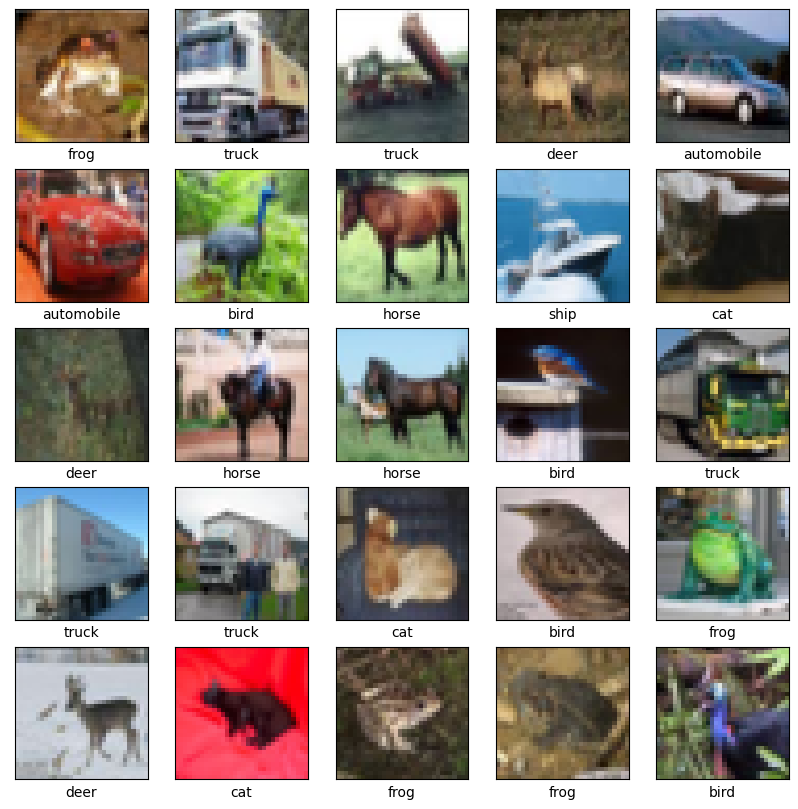

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    #the CIFAR labels happen to be arrays which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    
plt.show()


<h1>create the convolutional base</h1>
<p>the code below defines the convolutional base using the common patern of a stack of <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D">Conv2D</a> and <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D">MaxPool2D</a> layers.</p>
    
<br>
    
<p>As an input, a CNN takes in <b>tensors of shape (Image_height, Image_width, Color_channels)</b>, ignoring the batch size.</p>

In [4]:
#the sequential model describes a model that takes in a single input and gives a single output
model =  models.Sequential()

#convolutional layer convolves a set of (32 in this case) filters against the image 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
#max pool convolves (kinda) a filter across images, taking the maximum value across each pass of the filter
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [5]:
"""
    to calculate the number of learnable parameters of a CNN you multiply the width of the filter, the height of the filter, 
        and the number of input filter (or channels). then add 1 to account for the bias term. and finally multply by the total number of filters
        
    ex: conv2d_1 (kernel shape (3, 3), input filters (input channels since it's first) = 3, 32 total kernels) (((3*3*3)+1)*32 = 28*32 = 896
"""
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


<p>the output of every Conv2D and MaxPooling2D layer is a 3d tensor of shape (height, width, channels) [could be more!]. the width and height dimensions tend to shrink (since the image isn't padded before convolving). the number of output channels for each Conv2D layer is controlled by the first argument (the number of kernels).</p>

<br>

<h2>Add Dense Layers on top</h2>
<p>to complete the model, you feed the last output tensor from the CNN base into one or more dense layers. these (conceptually) perform the classification task. each Dense layer takes in a vector (which are 1D). to pass from a 3D tensor, you have to flatten (or unroll) the 3D output into a 1D output. And then finally add one or more Dense layers on top. Since CIFAR has 10 output classes, you should have a final dense layer with 10 outputs</p>

<a href="https://keras.io/api/layers/reshaping_layers/flatten/">Keras Flatten Layer</a>
<br>
<a href="https://keras.io/api/layers/core_layers/dense">Keras Dense Layer</a>

In [6]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [7]:
#to calculate dense layer parameters, multiply the number of neurons (activation size) in the current layer with the number of nerons (or activation size) 
#    in the previous layer plus 1 for the bias term. (current * (previous + 1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

<p>this model takes in a rgb color image (32, 32, 3), and processes it down into ten outputs (which hopefully model our problem!)</p>

<h2>Compile and Train the Model</h2>

<p>the training step uses the adam optimizer and cross entropy loss to optimize the parameters (learnable weights). and it goes through the dataset over ten epochs; meaning that it shuffles and trains over the dataset ten different times</p>

In [8]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#note: it seems like there is a such thing as "too many Epochs"
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#around 10 seems to be good for this
history = model.fit(train_images, train_labels, epochs=40, validation_data=(test_images, test_labels), shuffle=True)

Epoch 1/40
1563/1563 [==============================] - 18s 6ms/step - loss: 1.7899 - accuracy: 0.3390 - val_loss: 1.2712 - val_accuracy: 0.5432
Epoch 2/40
1563/1563 [==============================] - 3s 2ms/step - loss: 1.2382 - accuracy: 0.5556 - val_loss: 1.1078 - val_accuracy: 0.6114
Epoch 3/40
1563/1563 [==============================] - 3s 2ms/step - loss: 1.0447 - accuracy: 0.6294 - val_loss: 1.0205 - val_accuracy: 0.6365
Epoch 4/40
1563/1563 [==============================] - 3s 2ms/step - loss: 0.9410 - accuracy: 0.6698 - val_loss: 0.9447 - val_accuracy: 0.6684
Epoch 5/40
1563/1563 [==============================] - 3s 2ms/step - loss: 0.8694 - accuracy: 0.6940 - val_loss: 1.0125 - val_accuracy: 0.6511
Epoch 6/40
1563/1563 [==============================] - 3s 2ms/step - loss: 0.8071 - accuracy: 0.7116 - val_loss: 0.8914 - val_accuracy: 0.6871
Epoch 7/40
1563/1563 [==============================] - 3s 2ms/step - loss: 0.7553 - accuracy: 0.7360 - val_loss: 0.8889 - val_accuracy

<h2>Evaluate the Model</h2>

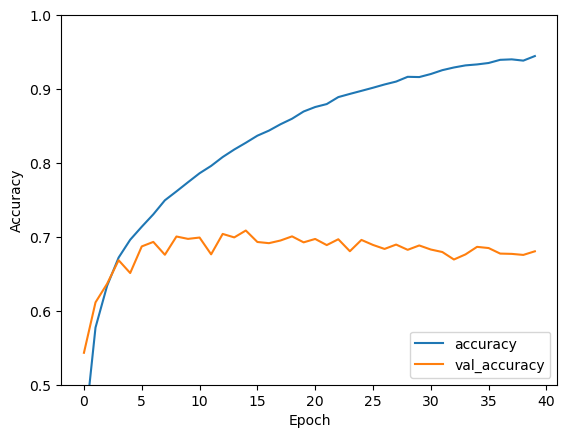

313/313 - 0s - loss: 2.2119 - accuracy: 0.6805


In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 2)

In [ ]:
#TODO: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/